In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
class PolynomialRegressor:
    
    def __init__(self, M, alpha, random_seed = 17):
        np.random.seed(random_seed)
        self.seed = random_seed
        self.alpha = alpha
        self.M = M+1
        self.weights = []
        for i in range(self.M):
            self.weights.append(np.random.uniform(-0.3,0.3))
            
    def copy(self):
        copied_reg = PolynomialRegressor(self.M-1, self.alpha, self.seed)
        copied_reg.weights = self.weights.copy()
        return copied_reg
    
    def predict(self, x):
            sum = 0
            for i in range(self.M):
                sum = sum + self.weights[i] * x**i
            return sum
        
    def predict_all(self, samples):
        preds = []
        for sample in samples:
            preds.append(self.predict(sample))
        return preds
    
    def get_MSE(self, samples):
        MSE = 0;
        for sample in samples:
            MSE = MSE + (self.predict(sample[0]) - sample[1])**2
        return MSE/len(samples)
        
    def fit(self, training_sample):
        A = []
        b = []
        for i in range(self.M):
            Ai = []
            Bi = 0
            for j in range(self.M):
                aij = 0
                for k in range(len(training_sample)):
                    aij = aij + training_sample[k][0]**(i+j)
                    if j == 0:
                        Bi = Bi + (training_sample[k][0]**i) * training_sample[k][1]
                if i == j:
                    aij = aij + self.alpha
                Ai.append(aij)
            b.append(Bi)
            A.append(Ai)
        self.weights = np.linalg.solve(A,b)
        
    def draw(self, a,b,n):
        x_points = []
        f_points = []
        for i in range(n):
            x = a + (b-a)/(n-1)*i
            x_points.append(x)
            f_points.append(self.predict(x))
        plt.plot(x_points, f_points,label = 'PolinomialRegressor', color = 'orange')
        plt.legend()

In [168]:
def draw_function(function, a,b, n):
    x_points = []
    f_points = []
    for i in range(n):
        x = a + (b-a)/(n-1)*i
        x_points.append(x)
        f_points.append(function(x))
    plt.plot(x_points, f_points,label = 'Function', color = 'purple')
    plt.legend()

In [179]:
class ParametersPair:
    
    def __init__(self, M, alpha):
        self.M = M
        self.alpha = alpha
        
    def copy(self):
        return ParametersPair(self.M, self.alpha)
        
        
class GridSearch:
    
    def __init__(self, parameters, cv=3, random_state=17):
        self.cv = cv
        self.random_state = random_state
        self.parameters = parameters
        self.cv_modes = {"random": self.__get_random_subsamples, "asc": self.__get_ascending_subsamples}
        self.best_params = None
        self.best_estimator = None
        
    def fit(self, training_sample, cv_mode):
        score_results = {}
        subsamples = self.cv_modes[cv_mode](training_sample)
        
        for deg in self.parameters["M"]:
            for alpha in self.parameters["alpha"]:
                params = ParametersPair(deg, alpha)
                score_results[params] = self.__fit_estimator(subsamples, deg, alpha)

        self.best_params = self.__find_best_params(score_results)
        self.best_estimator = PolynomialRegressor(self.best_params.M-1, self.best_params.alpha)
        self.best_estimator.fit(training_sample)
        
    def __find_best_params(self, score_results):
        min_error = 100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
        best_params_pair = None
        for key in score_results.keys():
            if score_results[key] < min_error:
                min_error = score_results[key]
                best_params_pair = key.copy()
        return best_params_pair
   
    def __get_random_subsamples(self, training_sample):
        training_sample.shuffle()
        return self.__split_training_sample(training_sample)
        
    def __get_ascending_subsamples(self, training_sample):
        training_sample.sort()
        return self.__split_training_sample(training_sample)
    
    def __split_training_sample(self, training_sample):
        subsamples = []
        length = len(training_sample)
        for i in range(self.cv):
            start_idx = length//self.cv * i
            finish_idx = length//self.cv * (i+1)
            if i == self.cv-1:
                finish_idx = length
            subsamples.append(training_sample.get_subsample(start_idx, finish_idx))
        return subsamples

    def __fit_estimator(self, subsamples, M, alpha):
        estimator = PolynomialRegressor(M, alpha, random_seed=self.random_state)
        scores = []
        for i in range(len(subsamples)):
            clone_est = estimator.copy()
            for j in range(len(subsamples)):
                if(i != j):
                    clone_est.fit(subsamples[j])
            scores.append(clone_est.get_MSE(subsamples[i]))
        return np.mean(scores)

In [180]:
class TrainingSample:
    
    def __init__(self, n, a, b, f):
        self.n = n
        self.a = a
        self.b = b
        self.f = f
        self.samples = []
        
    def get_subsample(self, start, finish):
        result = TrainingSample(self.n, self.a, self.b, self.f)
        result.samples = self.samples[start:finish]
        return result

    def join(self, new_samples):
        if self.a == new_samples.a and self.b == new_samples.b:
            self.samples = self.samples + new_samples.samples
            self.n = self.n + new_samples.n
    
    def generate(self):
        for i in range(self.n):
            x = np.random.uniform(self.a, self.b)
            self.samples.append([x,self.f(x)+np.random.normal(loc = 0.0, scale = 0.09)])
    
    def generate_test_samples(self, m):
        result = TrainingSample(m, self.a, self.b, self.f)
        result.generate()
        return result
            
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, key):
        return self.samples[key]
    
    def shuffle(self):
        np.random.shuffle(self.samples)
        
    def sort(self):
        self.samples.sort()
    
    def draw(self):
        plt.scatter(np.array(self.samples)[:,0], np.array(self.samples)[:,1], label='samples')

Best params: M= 15 , alpha= 0.1
cv MSE= 0.02420178489702208


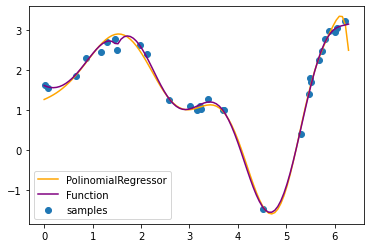

In [200]:
func = lambda x: np.sin(x)**2 + 1/2*np.cos(x) - np.cos(x*3)*1/5 + x * np.sin(x)**3 + np.abs(x-3/2)**(2/3)
train = TrainingSample(60,0,np.pi*2,func)
train.generate()
test = train.generate_test_samples(30)
grid = GridSearch({"M":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], "alpha":[0.001,0.1,1,10,100,1000,2500,10000]})
grid.fit(train, "random")
reg = grid.best_estimator

print("Best params: M=", grid.best_params.M,", alpha=",grid.best_params.alpha)
test.draw()
reg.draw(0,2*np.pi,100)
print("cv MSE=", reg.get_MSE(test))
draw_function(func, 0, np.pi*2, 100)